In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from matplotlib import pyplot as plt

from tqdm import tqdm
from PIL import Image as Img
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/jessicali9530/celeba-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shreshthasingh011
Your Kaggle Key: ··········


100%|██████████| 1.33G/1.33G [00:37<00:00, 38.0MB/s]


In [ ]:
import os

DATA_DIR = './celeba-dataset'
print(os.listdir(DATA_DIR))

['list_eval_partition.csv', 'list_attr_celeba.csv', 'img_align_celeba', 'list_bbox_celeba.csv', 'list_landmarks_align_celeba.csv']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

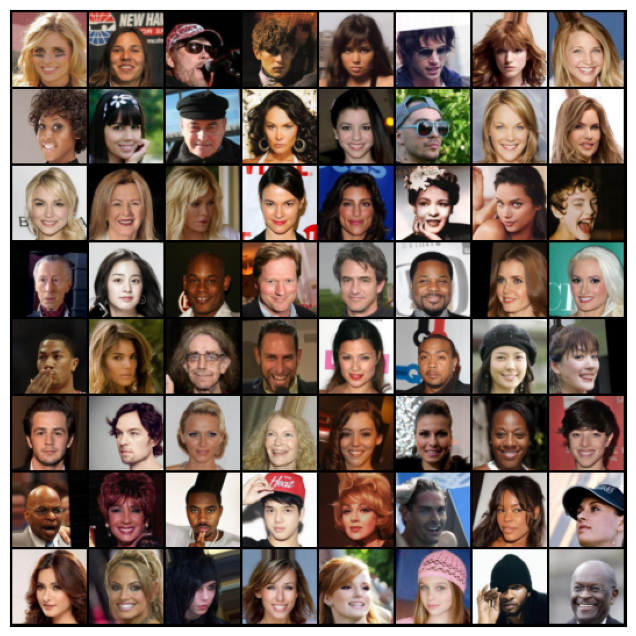

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


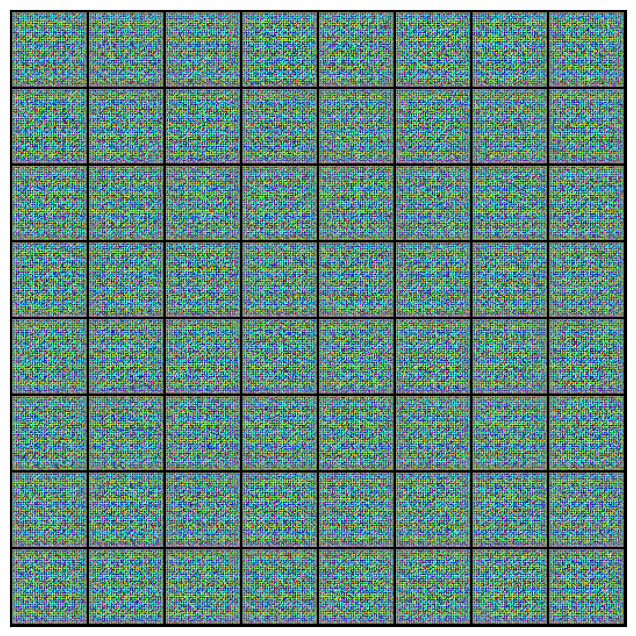

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()   #decriminator's optimizer-modify weights of descriminitor
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


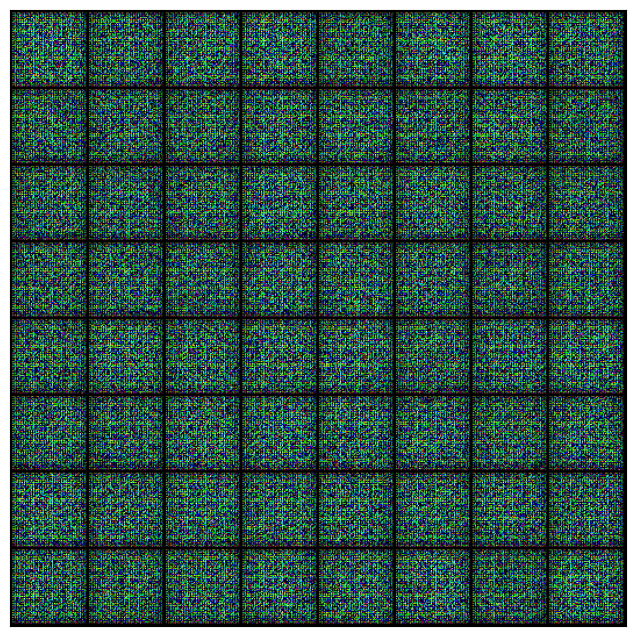

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 25

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 1.8037, loss_d: 0.7523, real_score: 0.5368, fake_score: 0.0100
Saving generated-images-0001.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 3.3864, loss_d: 0.2673, real_score: 0.8812, fake_score: 0.1171
Saving generated-images-0002.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 2.6880, loss_d: 0.4453, real_score: 0.6926, fake_score: 0.0150
Saving generated-images-0003.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 10.9411, loss_d: 2.3841, real_score: 0.9968, fake_score: 0.8473
Saving generated-images-0004.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 4.2226, loss_d: 0.0973, real_score: 0.9456, fake_score: 0.0354
Saving generated-images-0005.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 1.7100, loss_d: 0.9439, real_score: 0.4992, fake_score: 0.0041
Saving generated-images-0006.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 7.8947, loss_d: 0.2686, real_score: 0.9893, fake_score: 0.2079
Saving generated-images-0007.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.9998, loss_d: 0.1076, real_score: 0.9647, fake_score: 0.0621
Saving generated-images-0008.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 4.9585, loss_d: 0.0781, real_score: 0.9568, fake_score: 0.0304
Saving generated-images-0009.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 4.8034, loss_d: 0.1092, real_score: 0.9473, fake_score: 0.0447
Saving generated-images-0010.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 6.0678, loss_d: 0.2466, real_score: 0.9827, fake_score: 0.1832
Saving generated-images-0011.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 3.8803, loss_d: 0.1028, real_score: 0.9347, fake_score: 0.0229
Saving generated-images-0012.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 3.6811, loss_d: 0.2162, real_score: 0.8629, fake_score: 0.0430
Saving generated-images-0013.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 2.3578, loss_d: 0.2961, real_score: 0.9866, fake_score: 0.2157
Saving generated-images-0014.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.4006, loss_d: 2.2905, real_score: 0.2240, fake_score: 0.0015
Saving generated-images-0015.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 3.7855, loss_d: 0.1525, real_score: 0.9191, fake_score: 0.0501
Saving generated-images-0016.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 3.0768, loss_d: 0.4973, real_score: 0.7759, fake_score: 0.1550
Saving generated-images-0017.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 1.6603, loss_d: 0.6252, real_score: 0.6203, fake_score: 0.0044
Saving generated-images-0018.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 4.8271, loss_d: 0.1223, real_score: 0.9818, fake_score: 0.0824
Saving generated-images-0019.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 3.9911, loss_d: 0.1006, real_score: 0.9240, fake_score: 0.0114
Saving generated-images-0020.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 6.2294, loss_d: 0.0914, real_score: 0.9872, fake_score: 0.0708
Saving generated-images-0021.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 4.5403, loss_d: 0.1873, real_score: 0.9664, fake_score: 0.1190
Saving generated-images-0022.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 5.3699, loss_d: 0.3819, real_score: 0.9369, fake_score: 0.2329
Saving generated-images-0023.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 6.3770, loss_d: 0.3015, real_score: 0.9934, fake_score: 0.2181
Saving generated-images-0024.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 6.4204, loss_d: 0.1005, real_score: 0.9934, fake_score: 0.0817
Saving generated-images-0025.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

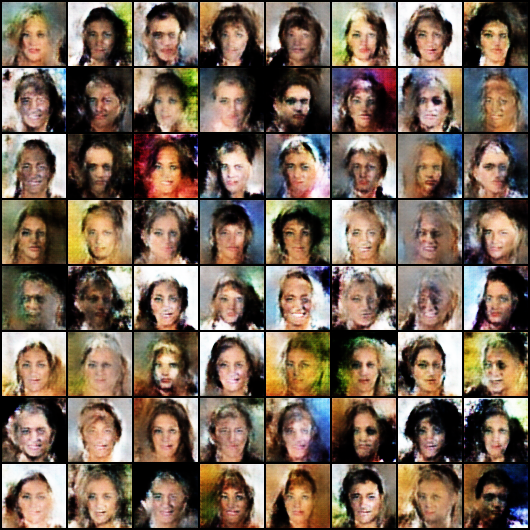

In [ ]:
Image('./generated/generated-images-0001.png')

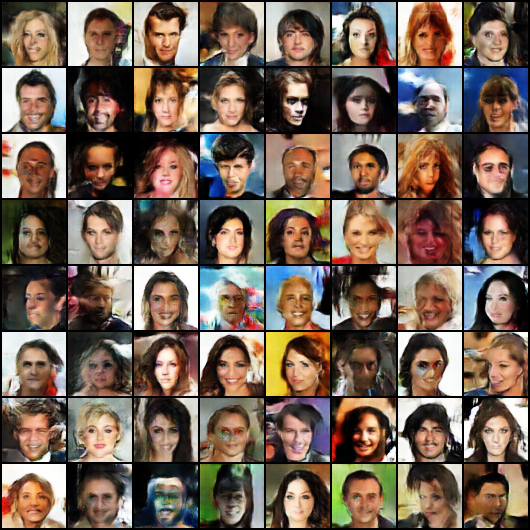

In [ ]:
Image('./generated/generated-images-0005.png')

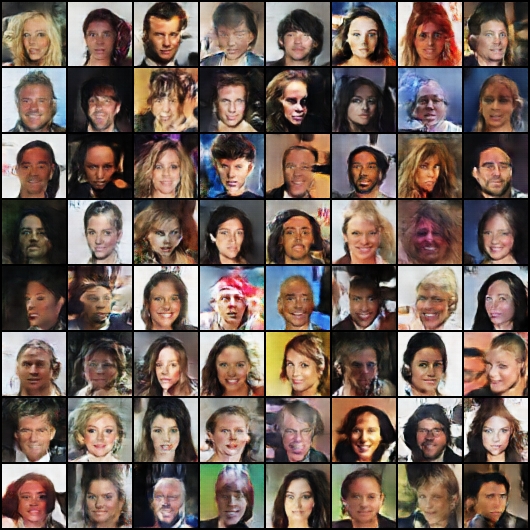

In [ ]:
Image('./generated/generated-images-0010.png')

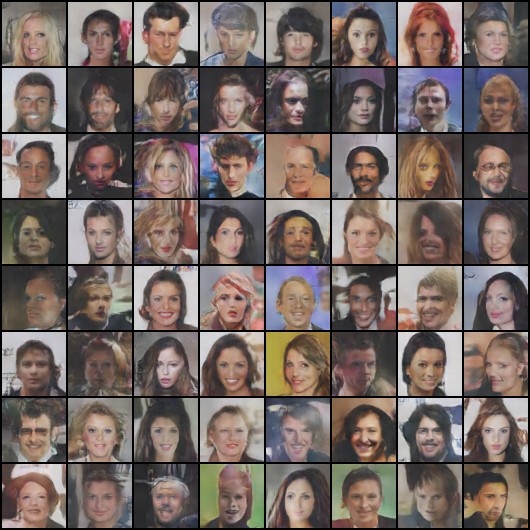

In [ ]:
Image('./generated/generated-images-0020.png')

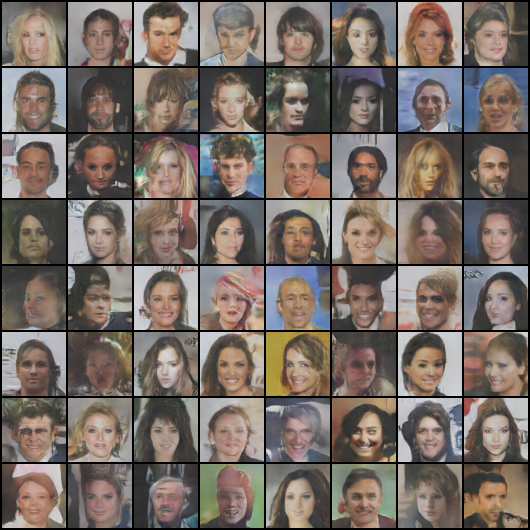

In [ ]:
Image('./generated/generated-images-0025.png')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

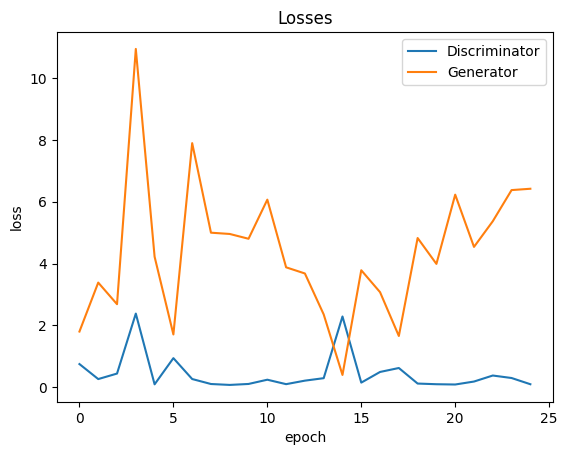

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

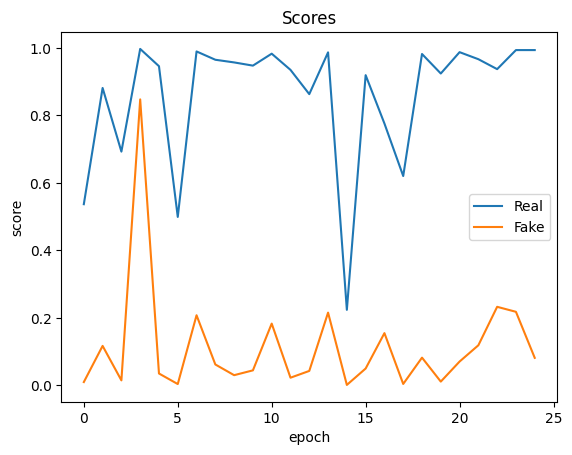

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');